<a target="_blank" href="https://colab.research.google.com/github/sky1ove/katlas/blob/main/nbs/tutorial_03a_enrichment_AKTi.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Kinase enrichment analysis - AKTi

In this session, we will analyze the differential change of phosphorylation sites in phosphoproteomics dataset.

## Setup

In [ ]:
!pip install python-katlas -Uq

In [ ]:
# katlas
from katlas.core import *
# from katlas.plot import plot_rank, set_sns

# utils
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce, partial
from tqdm import tqdm

# statistics
from scipy.stats import ttest_rel,ttest_ind
from statsmodels.stats.multitest import multipletests

# disable warning
import warnings
warnings.filterwarnings("ignore", message="converting a masked element to nan")

pd.set_option('display.precision', 15)

## Data

The phosphoproteomics dataset is from paper [Chemical Phosphoproteomics Sheds New Light on the Targets and Modes of Action of AKT Inhibitors](https://pubs.acs.org/doi/10.1021/acschembio.0c00872); five clinical AKT inhibitors are evaluated in this study.

<img width="700" src="https://github.com/sky1ove/katlas/raw/main/dataset/images/AKTi.png"/>

In [ ]:
df = pd.read_csv('https://github.com/sky1ove/katlas/raw/main/nbs/raw/AKT_inhibitor.csv')

In [ ]:
df.head()

,gene_site,site_seq,Control_R1,Control_R2,Control_R3,Control_R4,AZD5363_R1,AZD5363_R2,AZD5363_R3,AZD5363_R4,...,GSK690693_R3,GSK690693_R4,Ipatasertib_R1,Ipatasertib_R2,Ipatasertib_R3,Ipatasertib_R4,MK-2206_R1,MK-2206_R2,MK-2206_R3,MK-2206_R4
0,AAK1_S637,AGHRRILsDVtHsAV,14.167260000000001,13.791940000000000,13.888430000000000,13.991310000000000,14.581049999999999,14.802630000000001,14.723060000000000,14.857880000000000,...,14.47591,14.810269999999999,14.541550000000001,14.598560000000001,14.669480000000000,14.267690000000000,14.500560000000000,14.700110000000000,14.642170000000000,14.394790000000000
1,ABCF1_S105,MERLKKLsVPtsDEE,14.184260000000000,14.422390000000000,14.320520000000000,14.310689999999999,14.905970000000000,15.157950000000000,14.848050000000001,14.968950000000000,...,14.82788,14.924620000000001,14.888140000000000,15.019850000000000,14.857740000000000,14.809049999999999,14.915050000000001,14.815270000000000,15.067920000000001,14.526149999999999
2,ACIN1_S208,HSPRKSSsIsEEKGD,15.956730000000000,15.791060000000000,NaN,15.961280000000000,14.763690000000000,14.926340000000000,NaN,14.933990000000000,...,NaN,14.728800000000000,15.004510000000000,14.969420000000000,NaN,14.797020000000000,14.923180000000000,15.012650000000001,NaN,15.046220000000000
3,ACIN1_S216,IsEEKGDsDDEKPRK,17.457689999999999,16.997420000000002,17.373349999999999,17.434950000000001,16.252500000000001,16.341049999999999,16.316970000000001,16.411560000000001,...,16.38372,16.193570000000001,16.486070000000002,16.445869999999999,16.275169999999999,16.242329999999999,16.405529999999999,16.500750000000000,16.558160000000001,16.533030000000000
4,ACIN1_S240,QARAAkLsEGsQPAE,13.211040000000001,13.129730000000000,13.565530000000001,13.572440000000000,12.127129999999999,12.011320000000000,12.125540000000001,11.806080000000000,...,12.09775,12.322410000000000,11.838360000000000,12.090270000000000,12.027799999999999,11.561370000000000,12.093400000000001,12.152469999999999,12.159110000000000,11.888489999999999


In [ ]:
df.columns

Index(['gene_site', 'site_seq', 'Control_R1', 'Control_R2', 'Control_R3',
       'Control_R4', 'AZD5363_R1', 'AZD5363_R2', 'AZD5363_R3', 'AZD5363_R4',
       'GSK2110183_R1', 'GSK2110183_R2', 'GSK2110183_R3', 'GSK2110183_R4',
       'GSK690693_R1', 'GSK690693_R2', 'GSK690693_R3', 'GSK690693_R4',
       'Ipatasertib_R1', 'Ipatasertib_R2', 'Ipatasertib_R3', 'Ipatasertib_R4',
       'MK-2206_R1', 'MK-2206_R2', 'MK-2206_R3', 'MK-2206_R4'],
      dtype='object')

In [ ]:
ctrl = df.columns[df.columns.str.contains('Control')]

# below are five AKT inhibitors
AZD = df.columns[df.columns.str.contains('AZD5363')]
GSK2 = df.columns[df.columns.str.contains('GSK2110183')]
GSK6 = df.columns[df.columns.str.contains('GSK690693')] 
ipa = df.columns[df.columns.str.contains('Ipatasertib')]
MK = df.columns[df.columns.str.contains('MK')]

## Statistical test

Let's use AZD for example:

In [ ]:
azd = get_pvalue(df,ctrl, AZD,'mann_whitney')

Computing mann_whitney tests: 100%|██████████| 10900/10900 [00:10<00:00, 1061.00it/s]


In [ ]:
azd.head()

,log2FC,p_value,p_adj,signed_logP,signed_logPadj
0,0.822975000000001,0.028571428571429,0.186595908585124,1.544068044350276,0.729097883088899
1,0.621855000000000,0.028571428571429,0.186595908585124,1.544068044350276,0.729097883088899
2,-1.030390000000001,0.100000000000000,0.314892387693197,-1.000000000000000,-0.501837838006831
3,-1.075140000000001,0.028571428571429,0.186595908585124,-1.544068044350276,-0.729097883088899
4,-1.319855000000000,0.028571428571429,0.186595908585124,-1.544068044350276,-0.729097883088899


In [ ]:
azd.p_value.sort_values()

0        0.028571428571429
10584    0.028571428571429
2011     0.028571428571429
10585    0.028571428571429
10603    0.028571428571429
               ...        
7584     1.000000000000000
3648     1.000000000000000
9407     1.000000000000000
3654     1.000000000000000
10899    1.000000000000000
Name: p_value, Length: 10900, dtype: float64

As the sample size for calculating p value is small in this case, we will use uncorrected p_value to allow more data to be considered; it is more important to look at the effect size

In [ ]:
info = df.iloc[:,:2]

In [ ]:
azd = pd.concat([info,azd],axis=1)

## Cut through threshold

In [ ]:
# set a threshold of 0.05 for p_value
azd2 = azd[azd.p_value<0.05].reset_index(drop=True)

In [ ]:
azd2.shape

(1669, 7)

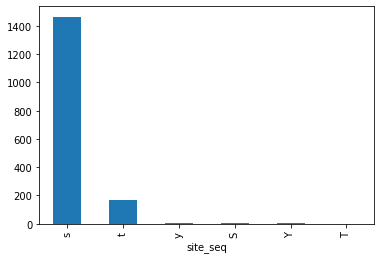

In [ ]:
azd2.site_seq.str[7].value_counts().plot.bar();

## Visualize fold change values

In [ ]:
def plot_value(df,col):
    plt.figure(figsize=(10, 5))
    
    # sort values
    df=df.copy().sort_values(col).reset_index(drop=True) 
    
    plt.fill_between(df.index, df[col], where=(df[col] >= 0), color='blue', alpha=0.3, label='Positive')
    plt.fill_between(df.index, df[col], where=(df[col] <= 0), color='red', alpha=0.3, label='Negative')
    plt.title('Area Plot of Values')
    plt.xlabel('Ranked Index')
    plt.ylabel('Values')

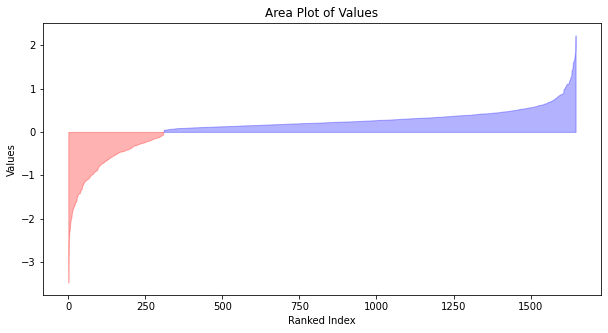

In [ ]:
plot_value(azd2,'log2FC')

In [ ]:
st_sites = azd2[azd2.site_seq.str[7].str.upper()!='Y']
y_sites = azd2[azd2.site_seq.str[7].str.upper()=='Y']

Text(0.5, 1.0, 'Y sites')

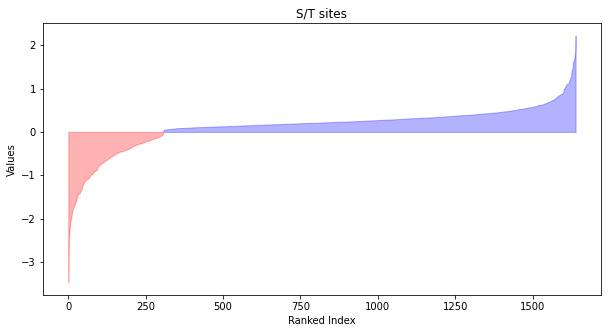

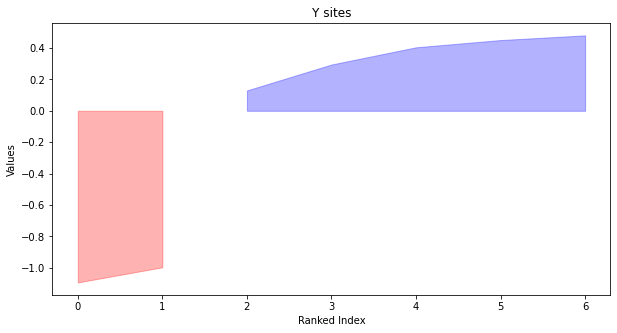

In [ ]:
plot_value(st_sites,'log2FC')
plt.title('S/T sites')
plot_value(y_sites,'log2FC')
plt.title('Y sites')

## Dataset processing

There are NaNs in site_seq, we will drop them

In [ ]:
azd2=azd2.dropna(subset='site_seq')

Some site_seq contains multiple sequences splitted by ";", we will take the first one.

In [ ]:
azd2['site_seq2'] = azd2.site_seq.str.split(';').str[0]

Make sure site sequence length are all consistent

In [ ]:
azd2['len'] = azd2.site_seq2.str.len()

In [ ]:
azd2.len.value_counts() 

len
15    1647
Name: count, dtype: int64

In [ ]:
azd2['acceptor'] = azd2.site_seq2.str[7]

## Substrate scoring

In [ ]:
pspa_out = predict_kinase_df(azd2,seq_col='site_seq2', **param_PSPA)
cddm_out = predict_kinase_df(azd2,seq_col='site_seq2', **param_CDDM)

input dataframe has a length 1647
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████| 396/396 [00:03<00:00, 114.38it/s]


input dataframe has a length 1647
Preprocessing
Finish preprocessing
Merging reference
Finish merging


## Kinase enrichment

In [ ]:
def get_enrichment(score_df, # output df of predict_kinase_df
                    site_df, # df that contains site sequence
                    weight_col, # column that indicates direction (sign) and weights for the site
                    is_Y=False, # whether or not it is Y site or S/T site
                    top_n = 5, # top n kinase to consider for each site
                                  ):

    "Calculate kinase enrichment score for sites with signed log10(p) that pass a threshold(1.3) "

    if is_Y:
        idx_up = site_df.index[(site_df.acceptor.str.upper()=="Y") & (site_df[weight_col]>0)]
        idx_dn = site_df.index[(site_df.acceptor.str.upper()=="Y") & (site_df[weight_col]<0)]
    else:
        idx_up = site_df.index[(site_df.acceptor.str.upper()!="Y") & (site_df[weight_col]>0)]
        idx_dn = site_df.index[(site_df.acceptor.str.upper()!="Y") & (site_df[weight_col]<0)]

    up_site = site_df.loc[idx_up]
    dn_site = site_df.loc[idx_dn]

    up_score = score_df.loc[idx_up]
    dn_score = score_df.loc[idx_dn]

    def top_kinases(site_row,top_n=5):
        # Sort the row in descending order and get the top n kinases
        top_kinases = site_row.sort_values(ascending=False).head(top_n)

        # Get the counts of the top kinases
        kinase_counts = top_kinases.index.value_counts()

        return kinase_counts

    func = partial(top_kinases,top_n=top_n)

    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)

    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')

    df_w_up = up_cnt.multiply(abs(up_site[weight_col]),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site[weight_col]),axis=0).sum().reset_index(name = 'dn_weighted_cnt')

    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]

    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)

    result = result.fillna(0)
    result['max'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['delta'] = result.up_weighted_cnt - result.dn_weighted_cnt
    result = result.rename(columns={'index':'kinase'})

    return result

As we only have 6 y sites, we will do S/T sites kinase enrichment; set`is_Y` to False

In [ ]:
st_cddm = get_enrichment(cddm_out,azd2,'log2FC',is_Y=False,top_n=10)
st_pspa = get_enrichment(pspa_out,azd2,'log2FC',is_Y=False,top_n=10)

In [ ]:
st_cddm.head()

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,max,delta
0,ACVR2A,19.0,3.0,5.507104999999999,0.896350000000004,5.507104999999999,4.610754999999996
1,AKT1,116.0,111.0,38.424563000000049,95.306570000000008,-95.306570000000008,-56.882006999999959
2,AKT2,14.0,66.0,4.007335000000003,64.575879999999998,-64.575879999999998,-60.568544999999993
3,AKT3,78.0,92.0,24.802710000000030,84.765155000000007,-84.765155000000007,-59.962444999999974
4,ALK2,94.0,14.0,22.789808500000021,6.202690000000000,22.789808500000021,16.587118500000020


Delta is the difference between up_weighted_cnt and dn_weighted_cnt vaue, max is the maximum value among the two.

In [ ]:
st_cddm.sort_values('delta')

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,max,delta
2,AKT2,14.0,66.0,4.007335000000003,64.575879999999998,-64.575879999999998,-60.568544999999993
3,AKT3,78.0,92.0,24.802710000000030,84.765155000000007,-84.765155000000007,-59.962444999999974
182,SGK1,72.0,95.0,23.715893000000033,83.583534999999998,-83.583534999999998,-59.867641999999961
1,AKT1,116.0,111.0,38.424563000000049,95.306570000000008,-95.306570000000008,-56.882006999999959
140,P90RSK,162.0,132.0,57.145470500000023,105.883935000000008,-105.883935000000008,-48.738464499999985
...,...,...,...,...,...,...,...
29,CDK2,589.0,72.0,178.796763500000026,41.434269500000013,178.796763500000026,137.362494000000027
28,CDK1,645.0,87.0,197.268107000000043,49.980519500000014,197.268107000000043,147.287587500000029
60,ERK1,650.0,79.0,199.277800000000013,42.192084500000021,199.277800000000013,157.085715499999992
31,CDK4,666.0,81.0,202.695893499999983,43.129879500000015,202.695893499999983,159.566013999999967


In [ ]:
st_cddm.sort_values('max')

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,max,delta
174,PRKX,285.0,136.0,104.613877000000002,109.507792000000023,-109.507792000000023,-4.893915000000021
140,P90RSK,162.0,132.0,57.145470500000023,105.883935000000008,-105.883935000000008,-48.738464499999985
1,AKT1,116.0,111.0,38.424563000000049,95.306570000000008,-95.306570000000008,-56.882006999999959
3,AKT3,78.0,92.0,24.802710000000030,84.765155000000007,-84.765155000000007,-59.962444999999974
182,SGK1,72.0,95.0,23.715893000000033,83.583534999999998,-83.583534999999998,-59.867641999999961
...,...,...,...,...,...,...,...
29,CDK2,589.0,72.0,178.796763500000026,41.434269500000013,178.796763500000026,137.362494000000027
28,CDK1,645.0,87.0,197.268107000000043,49.980519500000014,197.268107000000043,147.287587500000029
60,ERK1,650.0,79.0,199.277800000000013,42.192084500000021,199.277800000000013,157.085715499999992
31,CDK4,666.0,81.0,202.695893499999983,43.129879500000015,202.695893499999983,159.566013999999967


### Visualize in bar graph

In [ ]:
def get_bar_data(df, score_col, top_n = 10, plot=True):
    
    data = df.sort_values(score_col)[['kinase',score_col]]

    data.columns = ['Kinase','Score']
    
    data = pd.concat([data.head(top_n),data.tail(top_n)]).set_index('Kinase')
    
    if plot:
        data.plot.barh(legend=False)
        plt.title('Kinase Enrichment')
        plt.xlabel(f'{score_col} score')
        plt.ylabel('')
    
    return data

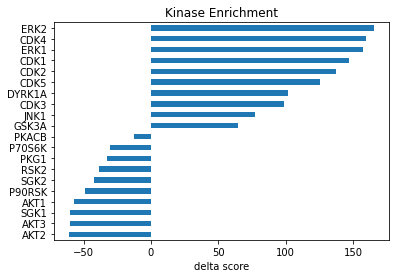

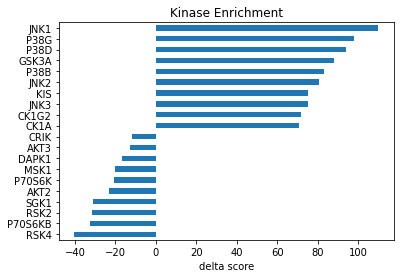

In [ ]:
bar_cddm = get_bar_data(st_cddm,'delta')

bar_pspa = get_bar_data(st_pspa,'delta')